In [1]:
#In Python, there is no lack of performance if we import several times the same module and / or package
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

In [4]:
class Temperatures(object):
    """A dataframe storing all temperatures we know
    Given the path name of the directory containing all Meteo France gzip files we want to use"""
    
    def __init__(self):
        "constructor"
        import pandas as pd
        self.df =  pd.DataFrame()
    
    def clean_temperatures(self) :
        list_outremer = [71805, 81408, 81415, 81405, 81401, 78894, 78890, 78897, 78922, 78925, 89642, 
                 61998, 61996, 61997, 61980, 61976, 61968, 67005, 61970, 61972]
        list_corsica = [7790,7761]
        #Convert temperature from Kelvin to Celsius degrees :
        self.df.loc[self.df.t == 'mq','t'] = np.nan
        self.df.t = pd.to_numeric(self.df.t)
        self.df.t = self.df.t - 273.15
        #Convert dates to DateTime format
        self.df.date = pd.to_datetime(self.df.date, format='%Y%m%d%H%M%S')
        #Remove stations that are not in continental France ("Outre-mer" and Corsica)
        self.df = self.df[(self.df.numer_sta.isin(list_outremer)== False) & (self.df.numer_sta.isin(list_corsica)==False)]
        #Compute temperature average
        grouped_temp =  self.df.groupby('date').t.mean()
        #Replace self.df by the average temperatures dataframe
        self.df = pd.DataFrame(grouped_temp).reset_index()
    
    def get_temperatures(self, mypath):
        """given a path name (do not forget '/' at the end) of the directory containing all Meteo France gzip files we want to use,
        Unzip the gzip files
        And insert them into the Temperatures instance"""
        import numpy as np
        from os import listdir
        from os.path import isfile, join
        
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        for file_name in onlyfiles :
            df_temp = pd.read_table(mypath+file_name,compression='gzip', sep = ';')
            df_temp = df_temp[['numer_sta', 'date', 't']]
            self.df = self.df.append(df_temp, ignore_index=True)
        self.clean_temperatures()
        
        
            

Tests sur la classe : (à supprimer par la suite)

In [5]:
#On crée une instance de la classe Temperatures qu'on nomme essai
essai = Temperatures()
#On va insérer les données dans l'instance grâce à l'instruction get_temperatures() en précisant le chemin du dossier
#où se trouvent les données
essai.get_temperatures('C:/Users/roman/Desktop/ENSAE 3A/HMM et Monte Carlo/Donnees temperature/')

In [6]:
essai.df.head()

,date,t
0,2011-01-01 00:00:00,3.012821
1,2011-01-01 03:00:00,2.725641
2,2011-01-01 06:00:00,2.317949
3,2011-01-01 09:00:00,2.625641
4,2011-01-01 12:00:00,4.176923


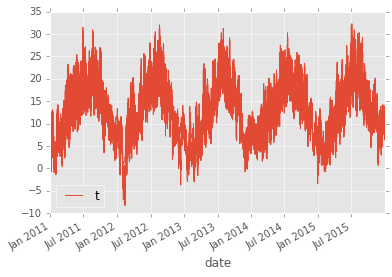

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

essai.df.plot(x='date', y = 't')

In [131]:
class Electricity(object):
    """A dataframe storing the consolidated half-hourly electricity load in France (except outre-mer and Corsica)
    Given the path name of the directory containing all RTE subdirectories we want to use"""
    
    def __init__(self):
        "constructor"
        import pandas as pd
        self.df =  pd.DataFrame()
    
    def clean_electricity(self) :
        import datetime
        #Get holiday dates in France using the library called workalendar
        from workalendar.europe import France
        cal = France()
        #Convert dates to DateTime format
        self.df['Date'] = pd.to_datetime(self.df['Date'], format='%d/%m/%Y')
        #Create the DayTypes mentioned in the article (except DayType 8)
        #/!\ We chose an arbitrary order to create the day types, since they are not separated sets
        #Add normal weekdays (DayType 1)
        self.df['Day_type'] = self.df['Date'].apply(lambda u : (u.date(), 1))
        #Add Mondays (DayType 0)
        self.df['Day_type'] = self.df['Day_type'].apply(lambda x : (x[0],0) if x[0].weekday()==0 else x)
        #Add Fridays (DayType 2)
        self.df['Day_type'] = self.df['Day_type'].apply(lambda x : (x[0],2) if x[0].weekday()==4 else x)
        #Add Saturdays (DayType 3)
        self.df['Day_type'] = self.df['Day_type'].apply(lambda x : (x[0],3) if x[0].weekday()==5 else x)
        #Add Sundays (DayType 4)
        self.df['Day_type'] = self.df['Day_type'].apply(lambda x : (x[0],4) if x[0].weekday()==6 else x)
        #Add Bank holidays (DayType 6)
        self.df['Day_type'] = self.df['Day_type'].apply(lambda x : (x[0],6) if cal.is_holiday(x[0])==True else x)
        #Add Before Bank holidays (DayType 5)
        self.df['Day_type'] = self.df['Day_type'].apply(lambda x : (x[0],5) if cal.is_holiday(x[0] + datetime.timedelta(days=1))==True else x)
        #Add After Bank holidays (DayType 7)
        self.df['Day_type'] = self.df['Day_type'].apply(lambda x : (x[0],7) if cal.is_holiday(x[0] - datetime.timedelta(days=1))==True else x)
        self.df['Day_type'] = self.df['Day_type'].apply(lambda x : x[1])
    
    def get_electricity_data(self, mypath):
        """given a path name (do not forget '/' at the end) of the directory containing all Meteo France gzip files we want to use,
        Unzip the gzip files
        And insert them into the Temperatures instance"""
        import numpy as np
        from os import listdir
        from os.path import isfile, join
        import warnings
        
        onlyfiles = [f + "/" + listdir(mypath + f)[0] for f in listdir(mypath)]
        for file_name in onlyfiles :
            df_temp = pd.read_excel(mypath+file_name, skiprows=range(17),  header = 1)
            #Drop empty lines separating each month on the Excel sheet
            df_temp = df_temp.dropna(axis = 0).reset_index(drop = True)
            #Check that df_temps has 365 rows (/!\ There can be leap years containing 366 days, that is why only a warning is raised here)
            if (len(df_temp) > 365) or (len(df_temp) < 365) :
                warnings.warn("WARNING : There is more than 365 days or less than 365 days in dataframe")
                print(file_name)
                print('Number of rows', len(df_temp))
            self.df = self.df.append(df_temp, ignore_index=True)
        self.clean_electricity()

In [132]:
#On crée une instance de la classe Temperatures qu'on nomme essai
essai = Electricity()
#On va insérer les données dans l'instance grâce à l'instruction get_electricity_data() en précisant le chemin du dossier
#où se trouvent les données
essai.get_electricity_data("C:/Users/roman/Desktop/ENSAE 3A/HMM et Monte Carlo/Donnees electricite/")

C:\Users\roman\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: UserWarning: WARNING : There is more than 365 days or less than 365 days in dataframe


Historique_consommation_INST_2012/Historique_consommation_INST_2012.xls
Number of rows 366


In [133]:
essai.df.head()

,Date,Type de données,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,24:00,Day_type
0,2011-01-01,Définitives,70671.0,68887.0,69045.0,68830.0,68143.0,65950.0,64343.0,62676.0,...,70926.0,70532.0,69433.0,68257.0,67221.0,68287.0,70497.0,69320.0,69062.0,6
1,2011-01-02,Définitives,67537.0,65099.0,65152.0,64785.0,64478.0,62594.0,61319.0,60084.0,...,75851.0,74972.0,73480.0,71938.0,70788.0,71380.0,73374.0,72138.0,71897.0,7
2,2011-01-03,Définitives,70483.0,68325.0,68628.0,68694.0,68715.0,67143.0,66038.0,65140.0,...,86672.0,84611.0,82317.0,80219.0,78181.0,78450.0,80072.0,78675.0,78509.0,0
3,2011-01-04,Définitives,76712.0,74313.0,74466.0,74199.0,74196.0,72428.0,71160.0,70052.0,...,88879.0,86587.0,84053.0,81787.0,79995.0,80119.0,81749.0,80214.0,79953.0,1
4,2011-01-05,Définitives,78121.0,75826.0,75627.0,75486.0,75425.0,73532.0,72180.0,71197.0,...,85901.0,83329.0,80561.0,78396.0,76036.0,75946.0,77336.0,75885.0,75385.0,1
